In [1]:
#%pip install --upgrade --force-reinstall torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 --user

In [1]:
import os
import optuna
import numpy as np
import pandas as pd
import yfinance as yf
import random
from gym import Env
from gym.spaces import Discrete, Box
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from enum import Enum
import talib
from sklearn.preprocessing import MinMaxScaler

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
        
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

In [3]:
def getTickerData(ticker, period, interval):
    hist = yf.download(tickers = ticker, period=period, interval=interval)
    df = pd.DataFrame(hist)
    df = df.reset_index()
    return df

In [4]:
def ssl_indicator(df):
    sma_high = talib.SMA(df['high'], 10)
    sma_low = talib.SMA(df['low'], 10)
    hlv = [np.nan]
    for i in range(0, len(df['close'])):
        if df['close'][i] > sma_high[i]:
            hlv.append(1)
        elif df['close'][i] < sma_low[i]:
            hlv.append(-1)
        else:
            hlv.append(hlv[i-1])

    ssl_down = [sma_high[i] if hlv[i] < 0 else sma_low[i] for i in range(len(df.close))]
    ssl_up = [sma_low[i] if hlv[i] < 0 else sma_high[i] for i in range(len(df.close))]

    signals = []
    for i in range(0, len(df.close)):
        if ssl_up[i-1] < ssl_down[i-1] and ssl_up[i] > ssl_down[i]:
            signals.append(1)
        elif ssl_up[i-1] > ssl_down[i-1] and ssl_up[i] < ssl_down[i]:
            signals.append(-1)
        else:
            signals.append(0)

    buy_signal = [True if signals[n]==1 else False for n in range(0, len(signals))]
    sell_signal = [True if signals[n]==-1 else False for n in range(0, len(signals))]
    
    return signals, buy_signal, sell_signal

In [5]:
def bbands_indicator(df):
    upper_bband_indicator, _, lower_bband_indicator = talib.BBANDS(df["close"], timeperiod=20)

    signals = []
    for i in range(0, len(df.close)):
        if upper_bband_indicator[i] < df['close'][i]:
            signals.append(-1)
        elif lower_bband_indicator[i] > df['close'][i]:
            signals.append(1)
        else:
            signals.append(0)

    buy_signal = [True if signals[n]==1 else False for n in range(0, len(signals))]
    sell_signal = [True if signals[n]==-1 else False for n in range(0, len(signals))]
    
    return signals, buy_signal, sell_signal

[*********************100%***********************]  1 of 1 completed


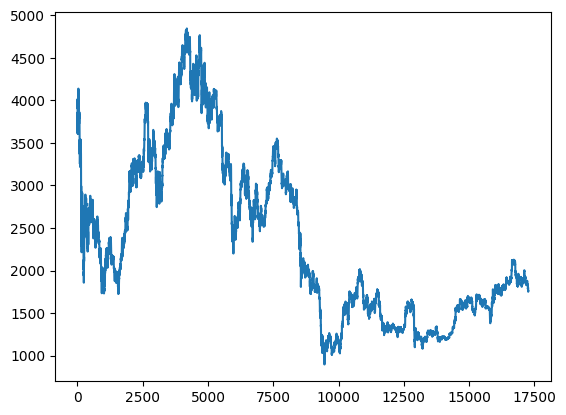

In [6]:
df = getTickerData('eth-usd', '730d', '1h')
df = df.rename(columns={'Close': 'close', 'Open': 'open', 'High': 'high', 'Low': 'low', 'Volume': 'volume', 'Datetime': 'date', 'Date': 'date'})
#df['date'] = pd.to_datetime(df['date'])

sma100_indicator = talib.SMA(df['close'], timeperiod=100)
mfi_indicator = talib.MFI(df['high'], df['low'], df['close'], df['volume'])
all_ssl_signals, _, _ = ssl_indicator(df=df)
_, macd_signal_indicator, macd_hist_indicator = talib.MACD(df["close"], fastperiod=12, slowperiod=26, signalperiod=9)
all_bbands_signals, _, _ = bbands_indicator(df=df)

df['sma_100'] = sma100_indicator
df['mfi'] = mfi_indicator
df['ssl_markover'] = all_ssl_signals
df['macd_signal'] = macd_signal_indicator   
df['macd_hist'] = macd_hist_indicator
df['bbands'] = all_bbands_signals

plt.plot(df['close'])

In [7]:
df = df.drop(columns={'volume', 'Adj Close', 'open', 'high', 'low', 'date'})
df = df.dropna()
df

,close,sma_100,mfi,ssl_markover,macd_signal,macd_hist,bbands
99,3525.751465,3806.729778,4.947407e+01,0,-109.507477,6.618926,0
100,3539.446045,3803.018091,5.724237e+01,1,-105.029693,17.911134,0
101,3508.514160,3798.223987,5.853064e+01,0,-99.271325,23.033475,0
102,3440.051514,3792.786331,6.230387e+01,0,-93.878195,21.572517,0
103,3515.456543,3788.653030,7.000762e+01,0,-87.579697,25.193993,0
...,...,...,...,...,...,...,...
17262,1768.963745,1837.659496,1.001515e+01,0,-13.278957,-1.924089,0
17263,1751.005859,1836.629486,6.891254e-12,0,-13.989961,-2.844015,1
17264,1755.908691,1835.557015,4.724317e-12,0,-14.697733,-2.831088,0
17265,1759.986328,1834.479417,2.068332e+01,0,-15.267822,-2.280353,0


In [8]:
scaler = MinMaxScaler()
t_df = scaler.fit_transform(df)
t_df = pd.DataFrame(t_df, columns=df.columns)
t_df

,close,sma_100,mfi,ssl_markover,macd_signal,macd_hist,bbands
0,0.666022,0.745848,4.947407e-01,0.5,0.242412,0.571326,0.5
1,0.669492,0.744842,5.724237e-01,1.0,0.257731,0.657636,0.5
2,0.661656,0.743543,5.853064e-01,0.5,0.277430,0.696787,0.5
3,0.644313,0.742069,6.230387e-01,0.5,0.295881,0.685621,0.5
4,0.663415,0.740949,7.000762e-01,0.5,0.317428,0.713301,0.5
...,...,...,...,...,...,...,...
17163,0.220993,0.212138,1.001515e-01,0.5,0.571618,0.506030,0.5
17164,0.216444,0.211858,2.392550e-12,0.5,0.569185,0.498998,1.0
17165,0.217686,0.211568,2.370881e-12,0.5,0.566764,0.499097,0.5
17166,0.218719,0.211276,2.068332e-01,0.5,0.564814,0.503306,0.5


In [9]:
def calculate_percentage_increase(final_value, starting_value):
    return 100 * ((final_value - starting_value) / starting_value)

In [10]:
class Positions(int, Enum):
    SHORT = 0
    LONG = 1
    HOLD = 2

In [33]:
class TradingEnv(Env):
    def __init__(self, df, n_steps, window_size) -> None:
        super().__init__()        
        self.df = df
        self.window_size = window_size
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(window_size, self.df.shape[1]), dtype=np.float64)
        self.action_space = Discrete(len(Positions))
        self.done = None
        
        self.current_step = 0
        self.n_steps = n_steps
        self.needed_space = self.window_size + self.n_steps
        self.random_index = random.randint(0, df.value_counts().sum() - self.needed_space-1)
        
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step-1]['close']
        
        self.positions = []
        self.current_pos = None
        self.held_price = 0
        self.in_a_pos = False
        
        self.trading_positions = 0
        self.profited_trading_positions = 0
        
        self.portfolio = 1
        
    def step(self, action):
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step-1]['close']
        
        reward, p, t = self.calculate_reward(action)
            
        if action != Positions.HOLD:
            self.current_pos = action
            self.held_price = self.final_value
            self.in_a_pos = True
            
        self.positions.append(action)
        
        self.current_step += 1
        if self.current_step >= self.n_steps:
            done = True
        else:
            done = False
            
        observation = self.get_observation()
        info = {'p': p, 't': t}
        
        return observation, reward, done, info
        
    def reset(self):
        next_observation = self.get_observation(is_random=True)
        self.random_index = random.randint(0, df.value_counts().sum() - self.needed_space-1)
        self.done = False
        self.current_step = 0
        self.positions.clear()
        next_observation = self.get_observation(is_random=True)
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step-1]['close']
        self.held_price = 0
        self.in_a_pos = False
        self.loss_positions = 0
        self.trading_positions = 0
        self.profited_trading_positions = 0
        self.portfolio = 1
        return next_observation
    
    def get_observation(self, is_random=False):
        if is_random:
            self.random_index = random.randint(0, df.value_counts().sum() - self.needed_space-1)
        return self.df.iloc[self.random_index+self.current_step:self.random_index+self.window_size+self.current_step, :].values
    
    def final_render(self):
        final_observation = self.df.iloc[self.random_index+self.window_size-1:self.random_index+self.window_size+len(self.positions)]['close']
        
        winrate = round(self.profited_trading_positions / self.trading_positions, 5)
            
        buy_signal = [True if self.positions[n]==Positions.LONG else False for n in range(0, len(self.positions))]
        sell_signal = [True if self.positions[n]==Positions.SHORT else False for n in range(0, len(self.positions))]
        hold_signal = [True if self.positions[n]==Positions.HOLD else False for n in range(0, len(self.positions))]
        buy_signal.append(False)
        sell_signal.append(False)
        hold_signal.append(False)
        
        plt.figure(figsize=(20,7))
        plt.plot(final_observation, color='c', lw=2.)
        plt.plot(final_observation, '^', markersize=10, color='g', label = 'Buying signal', markevery = buy_signal)
        plt.plot(final_observation, 'v', markersize=10, color='r', label = 'Selling signal', markevery = sell_signal)
        plt.plot(final_observation, 'o', markersize=6, color='b', label = 'Holding signal', markevery = hold_signal)
        plt.xticks([])
        plt.title("Final result of the last trading session")
        plt.ylabel('Close price')
        plt.legend()
        plt.show()
        
        return winrate
    
    def calculate_reward(self, action):
        """Calculate the reward function for the model here
        Example:\n
        reward = 1\n
        return reward"""
        raise NotImplementedError    

In [34]:
class Trading(TradingEnv):
    def __init__(self, df, n_steps, window_size) -> None:
        super().__init__(df, n_steps, window_size)
        
    def calculate_reward(self, action):
        reward = 0
        percentage = 0.
        total_profit = 0
        amount_to_use = 0.05

        if self.in_a_pos and action != Positions.HOLD:
            percentage = calculate_percentage_increase(self.final_value, self.held_price)
            if self.current_pos == Positions.SHORT:
                percentage = -percentage
                
            total_profit += ((self.portfolio * amount_to_use) * percentage)
            portfolio_change = self.portfolio + ((self.portfolio * amount_to_use) * percentage)
            self.portfolio = portfolio_change
            
            self.trading_positions+=1
            if reward > 0:
                self.profited_trading_positions+=1
            
            reward = total_profit
            
        return reward, percentage, total_profit

In [35]:
env = Trading(t_df, window_size=90, n_steps=100)
check_env(env)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\env_checker.py:213: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


REWARD 0
REWARD 0
REWARD -0.08559818716441539
REWARD -0.0006946379658077819
REWARD 0.04284409076978552
REWARD -0.006509570228762259
REWARD 0
REWARD -0.10612282347867913
REWARD 0
REWARD -0.11647653940048931
REWARD 0
REWARD 0.1269476998986466
REWARD 0
REWARD 0.04689628097794423
REWARD 0
REWARD -0.03472018789367792
REWARD 0.010895313275774735
REWARD -0.03785746423247338
REWARD 0.027813949738689996
REWARD -0.021652422341752384
REWARD 0.03875900580931424
REWARD 0.02542304745037997
REWARD 0
REWARD 0.04458220679781032
REWARD -0.005673113443452638
REWARD 0
REWARD 0
REWARD 0
REWARD 0.020326929331349962
REWARD 0
REWARD -0.022290364176404905
REWARD 0
REWARD 0
REWARD -0.05605972572430637
REWARD 0
REWARD 0
REWARD -0.08710971633187456
REWARD 0.006642523314462507
REWARD 0
REWARD 0
REWARD 0
REWARD -0.14088587387643764
REWARD 0
REWARD -0.004973709745419166
REWARD 0.0045430591251107615
REWARD 0.003915795479195601
REWARD 0
REWARD 0
REWARD 0
REWARD 0.02617138291782302
REWARD 0
REWARD 0.004879658008457008


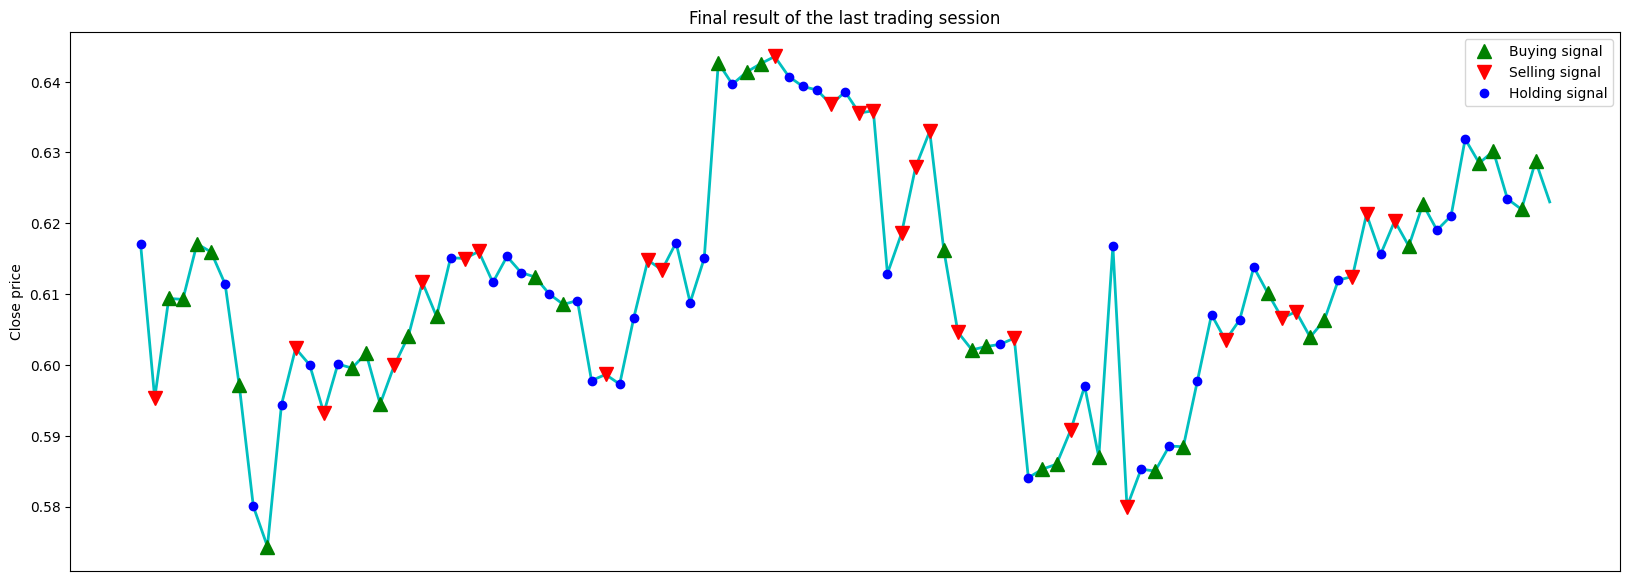

episode - 1 || score - -0.056106983594486314
0.0
-0.056106983594486314


In [37]:
episodes = 1
for n in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0
    ss = 0
    total_profit_ = 0
    while not done:
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        score += reward
        print('REWARD', reward)
        #print('TOTAL_PROFIT', info['t'])
        total_profit_ += info['t']
    winrate = env.final_render()
    print(f'episode - {n} || score - {score}')
    print(winrate)
    print(total_profit_)

In [15]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'
OPT_DIR = './opt/'

In [16]:
callback = TrainAndLoggingCallback(check_freq=100000, save_path=CHECKPOINT_DIR)

In [223]:
def optimize_ppo(trial):
    return {
        'n_steps': trial.suggest_int('n_steps', 64, 8192),
        'gamma': trial.suggest_loguniform('gamma', 0.8, 0.9999),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-6, 1e-4),
        'clip_range': trial.suggest_uniform('clip_range', 0.1, 0.4),
        'gae_lambda': trial.suggest_uniform('gae_lambda', 0.8, 0.99),
        'ent_coef': trial.suggest_uniform('ent_coef', 0.001, 0.01)
    }

In [224]:
def optimize_agent(trial):
    try:
        model_params=optimize_ppo(trial)
        env = Trading(df, window_size=90, n_steps=100)
        
        model = RecurrentPPO('MlpLstmPolicy', env, verbose=0, tensorboard_log=LOG_DIR, **model_params)
        model.learn(100000)
        
        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5)
        env.close()
        
        SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(trial.number))
        model.save(SAVE_PATH)
        
        return mean_reward
    except Exception as e:
        return -1000

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(optimize_agent, n_trials=35, n_jobs=1)

In [ ]:
study.best_params

{'n_steps': 7917,
 'gamma': 0.8148319613766952,
 'learning_rate': 1.1494222672968137e-05,
 'clip_range': 0.11454224768088915,
 'gae_lambda': 0.9747187305774679,
 'ent_coef': 0.007806731954039324}

In [38]:
model = RecurrentPPO('MlpLstmPolicy', env, verbose=0, tensorboard_log=LOG_DIR, 
                     n_steps=7917,
                     gamma=0.8148319613766952, 
                     learning_rate=1.1494222672968137e-05,
                     clip_range=0.11454224768088915,
                     gae_lambda=0.9747187305774679,
                     ent_coef=0.007806731954039324)

In [96]:
loaded_model = RecurrentPPO.load('./saved_models/best_model_5900000_rrs', env=env)

In [ ]:
opt_model = RecurrentPPO.load('./saved_models/opt_model_training_1', env=env)

In [40]:
model.learn(total_timesteps=100000, callback=callback)

KeyboardInterrupt: 

In [41]:
evaluate_policy(model, env, n_eval_episodes=10)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(0.13284608596695763, 0.405126662764385)

In [18]:
evaluate_policy(loaded_model, env, n_eval_episodes=10)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(1.8287345030230426, 2.3768329558035974)

In [80]:
evaluate_policy(opt_model, env, n_eval_episodes=10)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(-0.006837816031838884, 0.07551070536538326)

In [42]:
def test_portfolio(model, starting_money, amount_to_use):
    obs = env.reset()
    done = False
    score = 0
    portfolio = starting_money
    portfolio_accumulation_results = []
    percentage_increase = 0
    total_profit_percentage = 0
    total_profit = 0
    
    while not done:
        action, lstm_cells = model.predict(obs)
        obs, reward, done, info = env.step(action)
        score += reward
        percentage_increase = info['p']
        
        total_profit += ((portfolio * amount_to_use) * percentage_increase)
        portfolio_change = portfolio + ((portfolio * amount_to_use) * percentage_increase)
        portfolio = portfolio_change
        
        portfolio_accumulation_results.append(portfolio_change)
        plt.plot(portfolio_accumulation_results)
        
    env.final_render()
    total_profit_percentage += calculate_percentage_increase(portfolio, starting_money)
    print(f'score - {score}')
    print(f'Profit percentage - {total_profit_percentage}')
    print(f'Profit - {total_profit}')

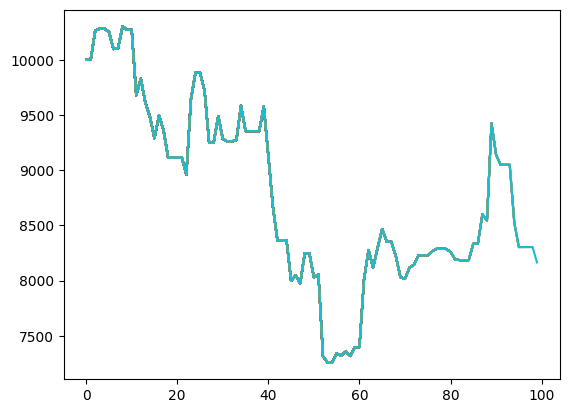

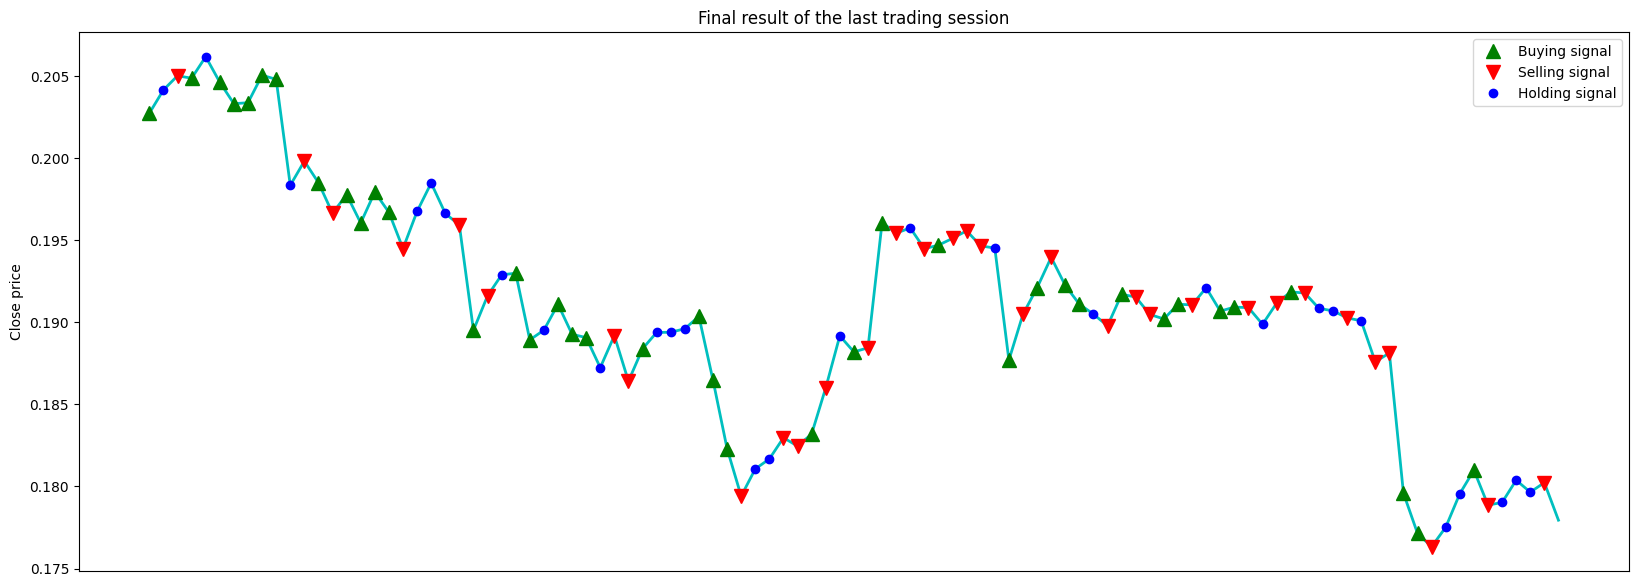

score - -0.18358483594420233
Profit percentage - -18.358483594420186
Profit - -1835.8483594420236


In [47]:
test_portfolio(model, starting_money=10000, amount_to_use=0.05)